<a href="https://colab.research.google.com/github/Overleaff/Neural_network/blob/main/Chap7_1ObjectDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import math
import os

In [ ]:
#!pip install opencv-contrib-python==4.4.0.44
#print(cv2.__version__)

# Viola-Jones detector

In [ ]:
!curl -O https://raw.githubusercontent.com/Overleaff/image/main/people/1girl.jpeg
image_path = "1girl.jpeg"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3726  100  3726    0     0  17742      0 --:--:-- --:--:-- --:--:-- 17742


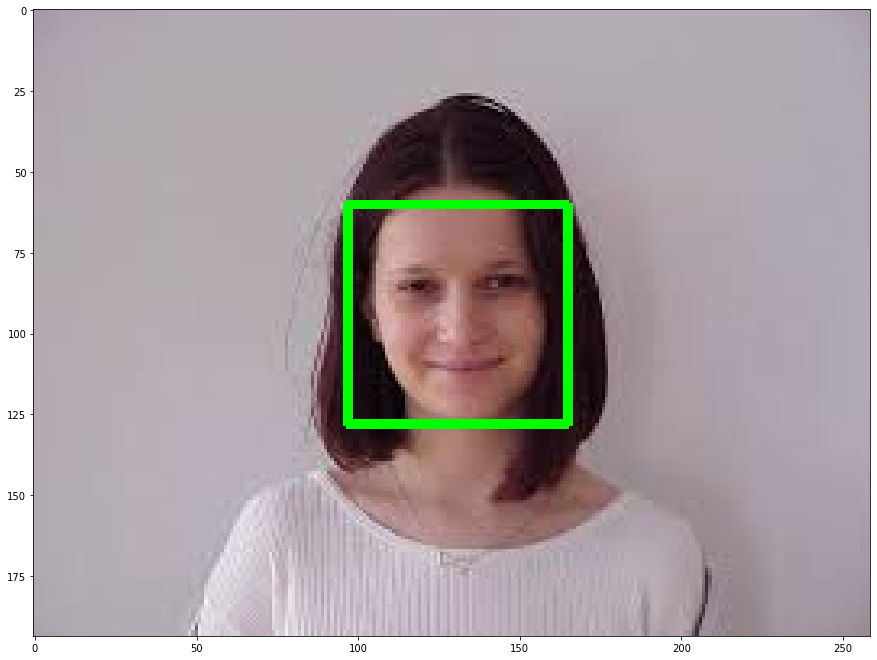

In [ ]:
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.imread(image_path, 0)

cascPathface = os.path.dirname(
    cv2.__file__) + "/data/haarcascade_frontalface_alt2.xml"
cascPatheyes = os.path.dirname(
    cv2.__file__) + "/data/haarcascade_eye_tree_eyeglasses.xml"

faceCascade = cv2.CascadeClassifier(cascPathface)
eyeCascade = cv2.CascadeClassifier(cascPatheyes)

faces = faceCascade.detectMultiScale(gray,
                                         scaleFactor=1.05,
                                         minNeighbors=3,
                                         minSize=(9, 9),
                                         flags=cv2.CASCADE_SCALE_IMAGE)
for (x,y,w,h) in faces:
   cv2.rectangle(img, (x, y), (x + w, y + h),(0,255,0), 2)
   faceROI = img[y:y+h,x:x+w]
   eyes = eyeCascade.detectMultiScale(faceROI)
   for (x2, y2, w2, h2) in eyes:
       eye_center = (x + x2 + w2 // 2, y + y2 + h2 // 2)
       radius = round((w2 + h2) * 0.25)
       cv2.circle(img, eye_center, radius, (255, 0, 0), 1)

fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(img)
plt.show()

# SVM + HOG

# Object detection

Proposal using selective search

In [ ]:
!curl -O https://raw.githubusercontent.com/Overleaff/image/main/car/43064.jpg
image_path = "43064.jpg"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  568k  100  568k    0     0  2000k      0 --:--:-- --:--:-- --:--:-- 2000k


In [ ]:
# this is the model we'll be using for
# object detection
from tensorflow.keras.applications import Xception
 
# for preprocessing the input
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing.image import img_to_array
from imutils.object_detection import non_max_suppression
 
# read the input image
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# instanciate the selective search
# segmentation algorithm of opencv
search = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
 
# set the base image as the input image
search.setBaseImage(img)
 
# since we'll use the fast method we set it as such
search.switchToSelectiveSearchFast()
 
# you can also use this for more accuracy:
# search.switchToSelectiveSearchQuality()
rects = search.process()  # process the image

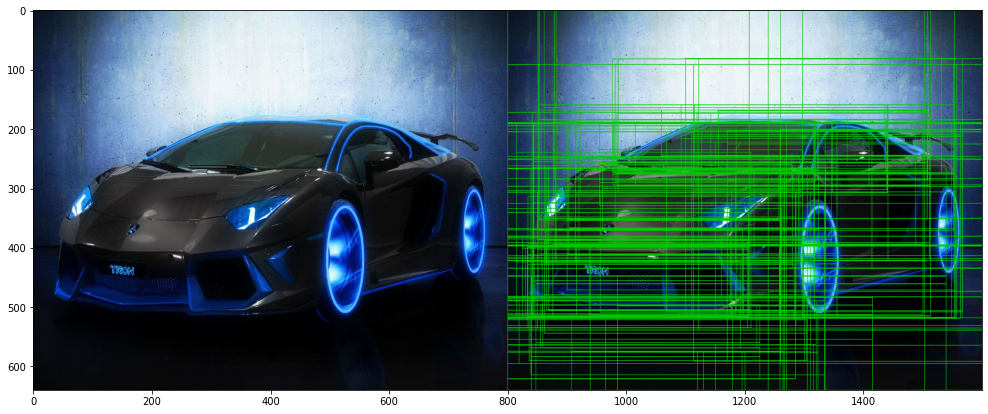

In [ ]:
roi = img.copy()
for (x, y, w, h) in rects:
 
    # Check if the width and height of
    # the ROI is atleast 10 percent
    # of the image dimensions and only then
    # show it
    
    if (w / float(img.shape[1]) < 0.4 or h / float(img.shape[2]) < 0.4):
        continue
 
    # Let's visualize all these ROIs
    cv2.rectangle(roi, (x, y), (x + w, y + h),
                  (0, 200, 0), 2)
 

roi = cv2.resize(roi, (800, 640))
final = cv2.hconcat([cv2.resize(img, (800, 640)), roi])

fig, ax = plt.subplots(figsize=(17,15))
ax.imshow(final)
plt.show()

In [ ]:
rois = []
boxes = []
(H, W) = img.shape[:2]
rois = []
boxes = []
(H, W) = img.shape[:2]
 
for (x, y, w, h) in rects:
   
    # check if the ROI has atleast
    # 20% the size of our image
    if w / float(W) < 0.2 or h / float(H) < 0.2:
        continue
 
    # Extract the Roi from image
    roi = img[y:y + h, x:x + w]
     
    # Convert it to RGB format
    roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
     
    # Resize it to fit the input requirements of the model
    roi = cv2.resize(roi, (299, 299))
 
    # Further preprocessing
    roi = img_to_array(roi)
    roi = preprocess_input(roi)
 
    # Append it to our rois list
    rois.append(roi)
 
    # now let's store the box co-ordinates
    x1, y1, x2, y2 = x, y, x + w, y + h
    boxes.append((x1, y1, x2, y2))

**model**

In [ ]:
model = Xception(weights='imagenet')

# Convert ROIS list to arrays for predictions
input_array = np.array(rois)
print("Input array shape is ;", input_array.shape)
 
#---------- Make Predictions -------#
preds = model.predict(input_array)
preds = imagenet_utils.decode_predictions(preds, top=1)# Integer, how many top-guesses to return. Defaults to 5.

Input array shape is ; (338, 299, 299, 3)


**initiate dictionary**

In [ ]:
# Initiate the dictionary
objects = {}
for (i, pred) in enumerate(preds):
   
    # extract the prediction tuple
    # and store it's values
    iD = pred[0][0]
    label = pred[0][1]
    prob = pred[0][2]
 
    if prob >= 0.9:
 
        # grab the bounding box associated
        # with the prediction and
        # convert the coordinates
        box = boxes[i]
 
        # create a tuble using box and probability
        value = objects.get(label, [])
         
        # append the value to the list for the label
        value.append((box, prob))
         
        # Add this tuple to the objects dictionary
        # that we initiated
        objects[label] = value

[0.9262771  0.93736356 0.9321618  0.9226175  0.9083344  0.93290406
 0.94348586 0.9387482  0.92246467 0.93363625 0.94617516 0.94575375
 0.9561003  0.9405885  0.9200909  0.93882567 0.9102321  0.93125755
 0.91740847 0.93784887 0.9308633  0.9000701  0.9220708  0.9096745
 0.9014061  0.9253652  0.9031885  0.9075352  0.9245418  0.9161668
 0.93972504 0.927282   0.9482165  0.9037595  0.90508026 0.90880185
 0.91341144 0.9187991  0.9386473  0.9344826  0.9137381  0.94359386
 0.93142515 0.91138816 0.91010374 0.91481215 0.9443598  0.90981865
 0.9435908  0.95504856]


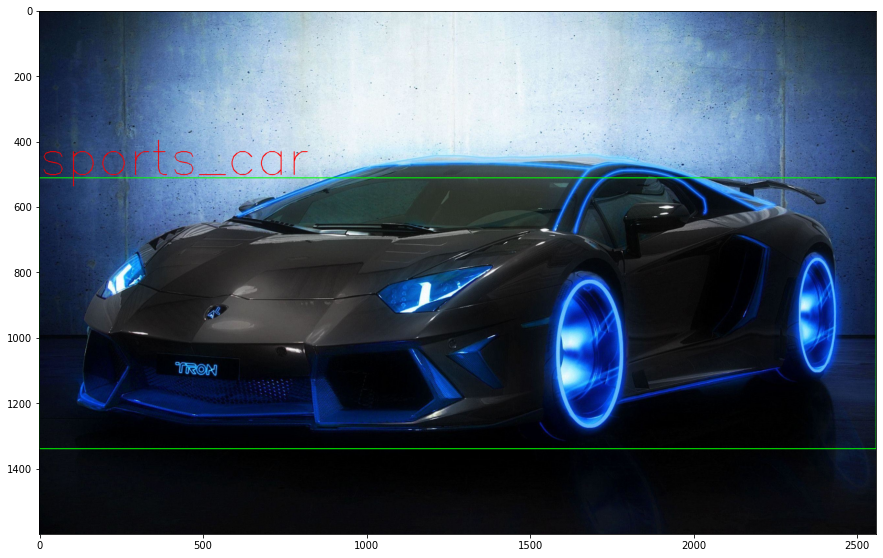

In [ ]:
# Loop through the labels
# for each label apply the non_max_suppression
for label in objects.keys():
   
    # clone the original image so that we can
    # draw on it
    img_copy = img.copy()
    boxes = np.array([pred[0] for pred in objects[label]])
    proba = np.array([pred[1] for pred in objects[label]])
    boxes = non_max_suppression(boxes, proba)
 
    # Now unpack the co-ordinates of the bounding box
    (startX, startY, endX, endY) = boxes[0]
 
    # Draw the bounding box
    cv2.rectangle(img_copy, (startX, startY),
                  (endX, endY), (0, 255, 0), 2)
    y = startY - 10 if startY - 10 > 10 else startY + 10
 
    # Put the label on the image
    cv2.putText(img_copy, label, (startX, y),
                cv2.FONT_HERSHEY_SIMPLEX, 5, (255, 0), 2)
    
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(img_copy)
plt.show()